In [614]:
import gym
import numpy as np
import random
from timeit import default_timer as timer
from datetime import timedelta
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import re
from mdptoolbox import mdp



In [698]:
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
np.random.seed(2)
sixteen = generate_random_map(16)
np.random.seed(44)
tvelve = generate_random_map(12)
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "12x12": tvelve,
    "16x16": sixteen
}

In [ ]:
def test_policy(env, policy, max_iterations=1000,  n_epoch=1000):
    '''

    :param env: mdp probelm
    :param policy: mdp policy
    :param max_iterations: maximum steps allowed to achieve
    :param n_epoch: number of trials
    :return: mean_reward, mean_eps, rewards, episode_counts
    '''

    rewards = []
    episode_counts = []
    for i in range(n_epoch):
        current_state = env.reset()
        ep = 0
        done = False
        episode_reward = 0
        while not done and ep < max_iterations:
            ep += 1
            act = int(policy[current_state])
            new_state, reward, done, _ = env.step(act)
            episode_reward += reward
            current_state = new_state

        rewards.append(episode_reward)

        episode_counts.append(ep)

    # all done
    mean_reward = sum(rewards)/len(rewards)

    mean_eps = sum(episode_counts)/len(episode_counts)
    return mean_reward, mean_eps, rewards, episode_counts

In [492]:
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
    return policy

def value_iteration(env,  lmbda=0.9, epsilon = 1e-3, max_iterations=100000):
    stateValue = [0 for i in range(env.nS)]
    newStateValue = stateValue.copy()
    start = timer()
    for j in range(max_iterations):
        for state in range(env.nS):
            action_values = []
            for action in range(env.nA):
                state_value = 0
                for i in range(len(env.P[state][action])):
                    prob, next_state, reward, done = env.P[state][action][i]
                    if done:
                        state_action_value = prob * reward
                    else:
                        state_action_value = prob * (reward + lmbda * stateValue[next_state])
                    state_value += state_action_value
                action_values.append(state_value)      #the value of each action
                best_action = np.argmax(np.asarray(action_values))   # choose the action which gives the maximum value
                newStateValue[state] = action_values[best_action] #update the value of the state
        if j > 1 and max(np.abs(np.array(stateValue) - np.array(newStateValue)))< epsilon:
            # if there is negligible difference break the loop
            end = timer()
            time_spent = timedelta(seconds=end-start)
            episode = j+1
            print("Solved in: {} episodes and {} seconds".format(episode, time_spent))
            policy = get_policy(env, stateValue, lmbda)
            break
        else:
            stateValue = newStateValue.copy()


    return policy, episode, time_spent, stateValue

In [709]:
def policy_iteration(env,  discount=0.9,  epsilon=1e-12, seed = 2, max_iteration = 10000):

    start = timer()

    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    ## 1. initialization - pick a policy randomly
    np.random.seed(seed)
    policy =  np.random.choice(range(env.nA), (1,env.nS))   # policy = np.random.randint(number_of_actions, size=(1,number_of_states))
#     policy = np.zeros((1,number_of_states))
    value_list = np.zeros((1, number_of_states))
    episode = 0
    sigma = discount

    ## 2. evaluate the policy
    policy_stable = False
    while not policy_stable:
        if episode > max_iteration:
            print('Stopped since the max_iteration has been reached!')
            break

        else:
            episode += 1
            eval_acc = True
            j = 0
            while eval_acc:
                eps = 0
                for s in range(number_of_states):
                    # first row
                    v = value_list[0][s]

                    # get the new value
                    a = policy[0][s]
                    total_val_new_state = 0
                    for prob, new_state, reward, done in env.P[s][a]:
                        value_new_state = value_list[0][new_state]
                        # second row
                        cand_value = 0
                        if done:
                            cand_value = reward
                        else:
                            cand_value = reward + sigma*value_new_state
                        total_val_new_state += cand_value*prob
                    value_list[0][s] = total_val_new_state

                    # third row
                    eps = max(eps, np.abs(v-value_list[0][s]))
                if eps < epsilon:
                    eval_acc = False


            ## 3. improve the policy
            policy_stable = True
            for s in range(number_of_states):

                # assign
                old_action = policy[0][s]
                # get the argmax a here
                max_value = -np.inf
                for a in range(number_of_actions):
                    # get the new value
                    total_cand_value = 0
                    for prob, new_state, reward, done in env.P[s][a]:
                        value_new_state = value_list[0][new_state]
                        cand_value = 0
                        if done:
                            cand_value = reward
                        else:
                            cand_value = reward + sigma*value_new_state
                        total_cand_value += prob*cand_value
                    if total_cand_value > max_value:
                        max_value = total_cand_value
                        policy[0][s] = a

                # if old-action != policy[s]
                if old_action != policy[0][s]:
                    policy_stable = False

    end = timer()
    time_spent = timedelta(seconds=end-start)
    policy = policy[0].tolist()
    value_list = value_list[0]
    print("Solved in: {} episodes and {} seconds".format(episode, time_spent))
    return policy, episode, time_spent, value_list

In [556]:
def grid_search_pi_vi(env, discount=[0.9], epsilon=[1e-9], mute=False):
    '''

    :param env: mdp problem
    :param discount: list of discount rate to be tested
    :param epsilon: list of epsilon to be tested
    :param mute: bool variable.
    :return: vi_dict, pi_dict
    '''

    vi_dict = {}

    for dis in discount:
        vi_dict[dis] = {}
        for eps in epsilon:
            vi_dict[dis][eps] = {}

            # run value iteration
            vi_policy, vi_solve_iter, vi_solve_time, vi_stateValue = value_iteration(env, dis, eps)
            vi_mrews, vi_meps, _, __ = test_policy(env, vi_policy)
            vi_dict[dis][eps]["mean_reward"] = vi_mrews
            vi_dict[dis][eps]["mean_eps"] = vi_meps

            vi_dict[dis][eps]["iteration"] = vi_solve_iter
            vi_dict[dis][eps]["time_spent"] = vi_solve_time
            vi_dict[dis][eps]["policy"] = vi_policy
            if not mute:
                print("Value iteration for {} discount and {} eps is done".format(dis, eps))
                print("Iteration: {} time: {}".format(vi_solve_iter, vi_solve_time))
                print("Mean reward: {} - mean eps: {}".format(vi_mrews, vi_meps))
    # run policy iteration
    pi_dict = {}
    for dis in discount:
        pi_dict[dis] = {}
        for eps in epsilon:
            pi_dict[dis][eps] = {}

            pi_policy, pi_solve_iter, pi_solve_time, pi_stateValue = policy_iteration(env, dis, eps)
            pi_mrews, pi_meps, _, __ = test_policy(env, pi_policy)
            pi_dict[dis][eps]["mean_reward"] = pi_mrews
            pi_dict[dis][eps]["mean_eps"] = pi_meps

            pi_dict[dis][eps]["iteration"] = pi_solve_iter
            pi_dict[dis][eps]["time_spent"] = pi_solve_time
            pi_dict[dis][eps]["policy"] = pi_policy
            if not mute:
                print("Policy iteration for {} discount is done".format(dis))
                print("Iteration: {} time: {}".format(pi_solve_iter, pi_solve_time))
                print("Mean reward: {} - mean eps: {}".format(pi_mrews, pi_meps))


    return vi_dict, pi_dict

In [571]:
env = gym.make('FrozenLake-v1')
vi_dict, pi_dict = grid_search_pi_vi(env, discount=[0.8,0.9], epsilon=[1e-3, 1e-4, 1e-5])

Solved in: 15 episodes and 0:00:00.015346 seconds
Value iteration for 0.8 discount and 0.001 eps is done
Iteration: 15 time: 0:00:00.015346
Mean reward: 0.438 - mean eps: 26.866
Solved in: 23 episodes and 0:00:00.027509 seconds
Value iteration for 0.8 discount and 0.0001 eps is done
Iteration: 23 time: 0:00:00.027509
Mean reward: 0.446 - mean eps: 26.384
Solved in: 32 episodes and 0:00:00.018640 seconds
Value iteration for 0.8 discount and 1e-05 eps is done
Iteration: 32 time: 0:00:00.018640
Mean reward: 0.473 - mean eps: 28.807
Solved in: 27 episodes and 0:00:00.016878 seconds
Value iteration for 0.9 discount and 0.001 eps is done
Iteration: 27 time: 0:00:00.016878
Mean reward: 0.747 - mean eps: 41.349
Solved in: 44 episodes and 0:00:00.026642 seconds
Value iteration for 0.9 discount and 0.0001 eps is done
Iteration: 44 time: 0:00:00.026642
Mean reward: 0.72 - mean eps: 40.798
Solved in: 61 episodes and 0:00:00.035514 seconds
Value iteration for 0.9 discount and 1e-05 eps is done
Iter

In [ ]:
vi_df = pd.DataFrame({(outerKey, innerKey): values for outerKey, innerDict in vi_dict.items() for innerKey, values in innerDict.items()})
pi_df = pd.DataFrame({(outerKey, innerKey): values for outerKey, innerDict in pi_dict.items() for innerKey, values in innerDict.items()})

In [568]:
vi_dict

{0.8: {0.001: {'mean_reward': 0.47,
   'mean_eps': 27.34,
   'iteration': 15,
   'time_spent': datetime.timedelta(0, 0, 11353),
   'policy': [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]},
  0.0001: {'mean_reward': 0.442,
   'mean_eps': 27.126,
   'iteration': 23,
   'time_spent': datetime.timedelta(0, 0, 27555),
   'policy': [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]},
  1e-05: {'mean_reward': 0.435,
   'mean_eps': 27.388,
   'iteration': 32,
   'time_spent': datetime.timedelta(0, 0, 33365),
   'policy': [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]}},
 0.9: {0.001: {'mean_reward': 0.707,
   'mean_eps': 41.72,
   'iteration': 27,
   'time_spent': datetime.timedelta(0, 0, 16493),
   'policy': [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]},
  0.0001: {'mean_reward': 0.745,
   'mean_eps': 40.504,
   'iteration': 44,
   'time_spent': datetime.timedelta(0, 0, 28771),
   'policy': [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]},
  1e-05: {'mean_reward': 0.721,
   'mean_eps'

In [560]:
pi_df

0.8  \
                                                      0.00100   
mean_reward                                             0.463   
mean_eps                                                27.05   
iteration                                                   4   
time_spent                                     0:00:00.002928   
policy       [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]   

                                                               \
                                                      0.00010   
mean_reward                                             0.447   
mean_eps                                                27.02   
iteration                                                   4   
time_spent                                     0:00:00.004991   
policy       [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]   

                                                               \
                                                      0.00001   
mean_reward                                             0.436   
mean_eps                                               26.771   
iteration                                                   5   
time_spent                                     0:00:00.006818   
policy       [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]   

                                                          0.9  \
                                                      0.00100   
mean_reward                                             0.732   
mean_eps                                               40.416   
iteration                                                   4   
time_spent                                     0:00:00.004394   
policy       [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]   

                                                               \
                                                      0.00010   
mean_reward                                             0.702   
mean_eps                                               40.741   
iteration                                                   4   
time_spent                                     0:00:00.007427   
policy       [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]   

                                                               
                                                      0.00001  
mean_reward                                             0.719  
mean_eps                                               40.305  
iteration                                                   4  
time_spent                                     0:00:00.010101  
policy       [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]

In [561]:
def map_discretize(the_map):
    size = len(the_map)
    dis_map = np.zeros((size,size))
    for i, row in enumerate(the_map):
        for j, loc in enumerate(row):
            if loc == "S":
                dis_map[i, j] = 0
            elif loc == "F":
                dis_map[i, j] = 0
            elif loc == "H":
                dis_map[i, j] = -1
            elif loc == "G":
                dis_map[i, j] = 1
    return dis_map

In [563]:
def policy_numpy(policy):
    size = int(np.sqrt(len(policy)))
    pol = np.asarray(policy)
    pol = pol.reshape((size, size))
    return pol


def see_policy(map_size, policy):
    map_name = str(map_size)+"x"+str(map_size)
    data = map_discretize(MAPS[map_name])
    np_pol = policy_numpy(policy)
    plt.imshow(data, interpolation="nearest")

    for i in range(np_pol[0].size):
        for j in range(np_pol[0].size):
            arrow = '\u2190'
            if np_pol[i, j] == 1:
                arrow = '\u2193'
            elif np_pol[i, j] == 2:
                arrow = '\u2192'
            elif np_pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="w")
    plt.show()

In [564]:
def plot_the_dict(dictionary, value="Score", size=4, variable="Discount Rate", log=False):

    plt.figure(figsize=(12, 8))
    title = "Average and Max {} on {}x{} Frozen Lake".format(value, size, size)
    the_val = value
    value = "Average {}".format(the_val)
    val_type = "Type of {}".format(the_val)
    the_df = pd.DataFrame(columns=[variable, value, val_type])
    for k, v in dictionary.items():
        for val in v:
            if not log:
                dic = {variable: k, value: float(val), val_type: "Average with std"}
            else:
                dic = {variable: np.log10(k), value: float(val), val_type: "Average with std"}
            the_df = the_df.append(dic, ignore_index=True)
        if not log:
            dic = {variable: k, value: float(max(v)), val_type: "Max"}
        else:
            dic = {variable: np.log10(k), value: float(max(v)), val_type: "Max"}
        the_df = the_df.append(dic, ignore_index=True)
    sns.lineplot(x=variable, y=value, hue=val_type, style=val_type, markers=True, data=the_df).set(title=title)


In [579]:
def convert_dict_to_dict(the_dict):

    # return for discount
    discount_rewards = {}
    discount_iterations = {}
    discount_times = {}


    for disc in the_dict:
        discount_rewards[disc] = []
        discount_iterations[disc] = []
        discount_times[disc] = []

        for eps in the_dict[disc]:
            discount_rewards[disc].append(the_dict[disc][eps]['mean_reward'])
            discount_iterations[disc].append(the_dict[disc][eps]['iteration'])
            discount_times[disc].append(the_dict[disc][eps]['time_spent'].total_seconds())


    epsilon_rewards = {}
    epsilon_iterations = {}
    epsilon_times = {}
    for eps in the_dict[0.5]:
        epsilon_rewards[eps] = []
        epsilon_iterations[eps] = []
        epsilon_times[eps] = []

        for disc in vi_dict:
            epsilon_rewards[eps].append(the_dict[disc][eps]['mean_reward'])
            epsilon_iterations[eps].append(the_dict[disc][eps]['iteration'])
            epsilon_times[eps].append(the_dict[disc][eps]['time_spent'].total_seconds())

    return discount_rewards, discount_iterations, discount_times, epsilon_rewards, epsilon_iterations, epsilon_times

In [ ]:
def convert_dict_to_dict(the_dict):

    # return for discount
    discount_rewards = {}
    discount_iterations = {}
    discount_times = {}


    for disc in the_dict:
        discount_rewards[disc] = []
        discount_iterations[disc] = []
        discount_times[disc] = []

        for eps in the_dict[disc]:
            discount_rewards[disc].append(the_dict[disc][eps]['mean_reward'])
            discount_iterations[disc].append(the_dict[disc][eps]['iteration'])
            discount_times[disc].append(the_dict[disc][eps]['time_spent'].total_seconds())


    epsilon_rewards = {}
    epsilon_iterations = {}
    epsilon_times = {}
    for eps in the_dict[the_dict.keys()[0]]:
        epsilon_rewards[eps] = []
        epsilon_iterations[eps] = []
        epsilon_times[eps] = []

        for disc in the_dict:
            epsilon_rewards[eps].append(the_dict[disc][eps]['mean_reward'])
            epsilon_iterations[eps].append(the_dict[disc][eps]['iteration'])
            epsilon_times[eps].append(the_dict[disc][eps]['time_spent'].total_seconds())

    return discount_rewards, discount_iterations, discount_times, epsilon_rewards, epsilon_iterations, epsilon_times

In [616]:
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
np.random.seed(2)
sixteen = generate_random_map(16)
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": generate_random_map(8),

    "16x16": sixteen
}

4x4 frozen lake

In [622]:
sns.set_style("whitegrid")

In [1410]:
env = gym.make("FrozenLake-v1")
env.render()


SFFF
FHFH
FFFH
HFFG


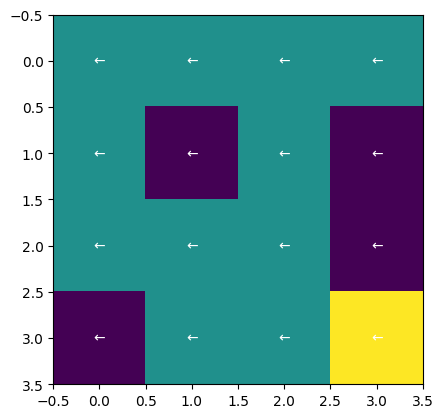

In [1411]:
import matplotlib
matplotlib.rc_file_defaults()
map_discretize(MAPS['4x4'])
see_policy(4,[0,]*16)

In [1417]:
vi_dict, pi_dict = grid_search_pi_vi(env, discount=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.9999],
                                        epsilon=[1e-3, 1e-6, 1e-9, 1e-12, 1e-15], mute=True)



Solved in: 7 episodes and 0:00:00.009698 seconds
Solved in: 16 episodes and 0:00:00.021936 seconds
Solved in: 25 episodes and 0:00:00.022564 seconds
Solved in: 34 episodes and 0:00:00.049213 seconds
Solved in: 44 episodes and 0:00:00.028177 seconds
Solved in: 8 episodes and 0:00:00.014331 seconds
Solved in: 20 episodes and 0:00:00.015784 seconds
Solved in: 33 episodes and 0:00:00.033048 seconds
Solved in: 45 episodes and 0:00:00.032858 seconds
Solved in: 57 episodes and 0:00:00.033372 seconds
Solved in: 11 episodes and 0:00:00.010654 seconds
Solved in: 27 episodes and 0:00:00.018958 seconds
Solved in: 44 episodes and 0:00:00.034862 seconds
Solved in: 61 episodes and 0:00:00.039238 seconds
Solved in: 78 episodes and 0:00:00.041580 seconds
Solved in: 15 episodes and 0:00:00.009099 seconds
Solved in: 40 episodes and 0:00:00.024369 seconds
Solved in: 65 episodes and 0:00:00.068916 seconds
Solved in: 90 episodes and 0:00:00.055510 seconds
Solved in: 115 episodes and 0:00:00.113955 seconds
S

Value Iteration

In [1420]:
discount_r, discount_i, discount_t, epsilon_r, epsilon_i, epsilon_t = convert_dict_to_dict(vi_dict)

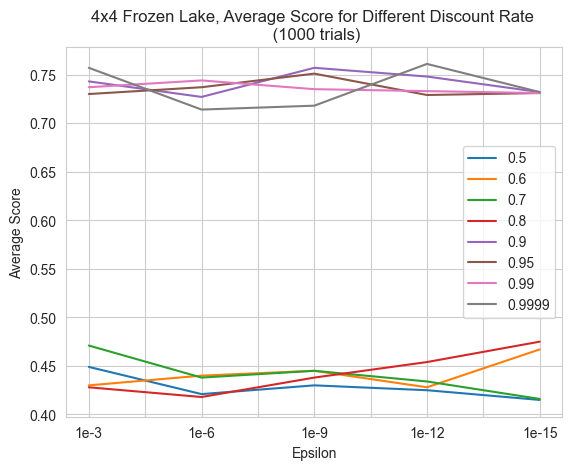

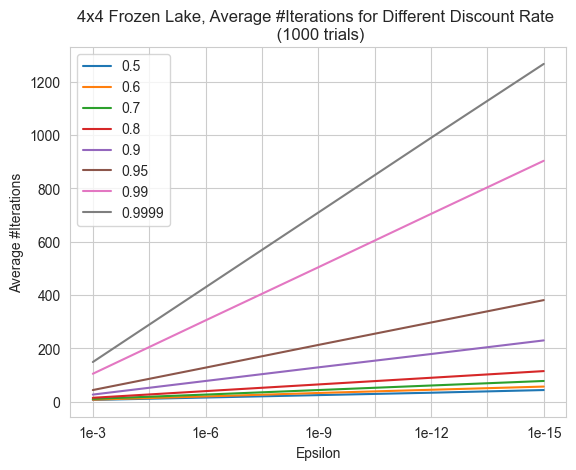

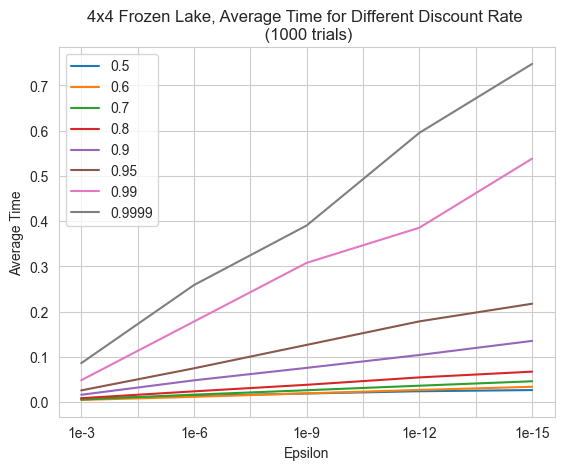

In [712]:
epsilon=['1e-3', '1e-6', '1e-9', '1e-12', '1e-15']
y_labels = ['Average Score', 'Average #Iterations', 'Average Time']
for i, d in enumerate([discount_r, discount_i, discount_t]):
    pd.DataFrame(d, index = epsilon).plot()
    plt.xlabel('Epsilon')
    plt.ylabel(y_labels[i])
    plt.title('4x4 Frozen Lake, {} for Different Discount Rate \n (1000 trials)'.format(y_labels[i]))

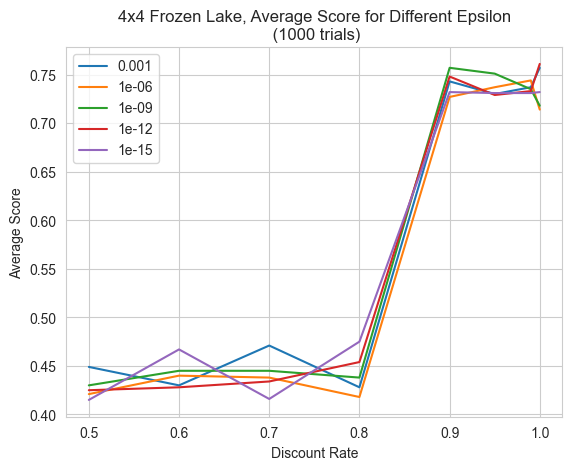

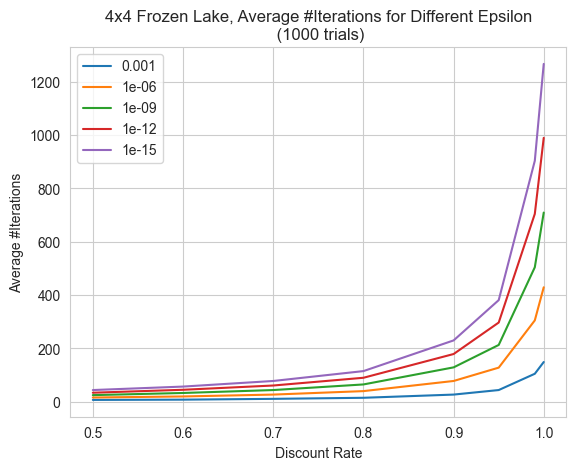

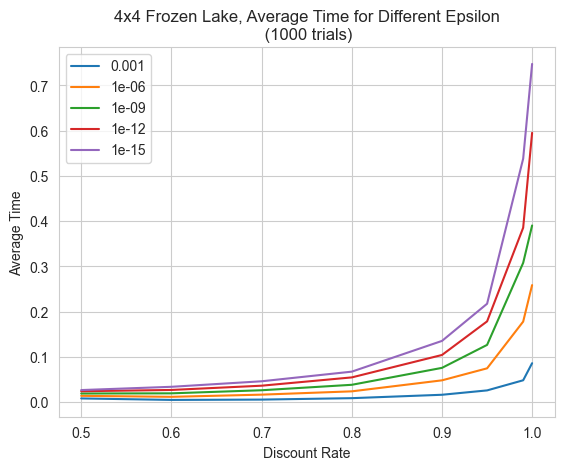

In [713]:
discount=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.9999]
y_labels = ['Average Score', 'Average #Iterations', 'Average Time']
for i, d in enumerate([epsilon_r, epsilon_i, epsilon_t]):
    pd.DataFrame(d, index = discount).plot()
    plt.xlabel('Discount Rate')
    plt.ylabel(y_labels[i])
    plt.title('4x4 Frozen Lake, {} for Different Epsilon\n (1000 trials)'.format(y_labels[i]))

In [1423]:
policies = {k:v[1e-6]['policy'] for k, v in vi_dict.items() if k in discount}
unique_p = []
for k,v in policies.items():
    if v not in unique_p:
        unique_p.append(v)

In [1424]:
policies

{0.5: [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.6: [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.7: [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.8: [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.9: [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.95: [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.99: [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.9999: [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]}

In [716]:
unique_p

[[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]]

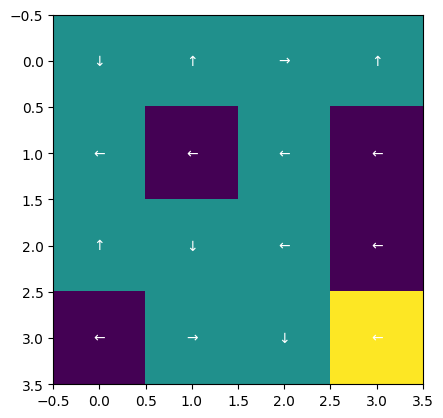

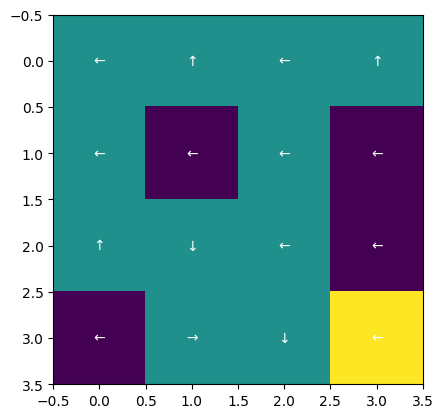

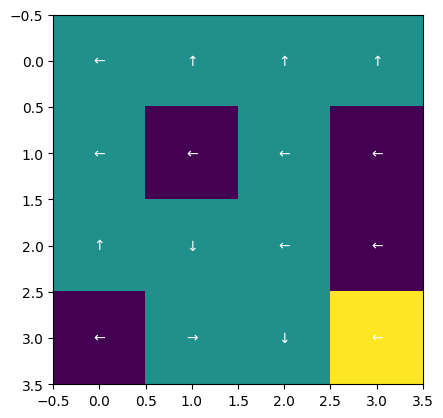

In [695]:
import matplotlib
matplotlib.rc_file_defaults()
for i in range(len(unique_p)):
    see_policy(env.action_space.n, unique_p[i])

Policy Iteration

In [717]:
discount_r, discount_i, discount_t, epsilon_r, epsilon_i, epsilon_t = convert_dict_to_dict(pi_dict)

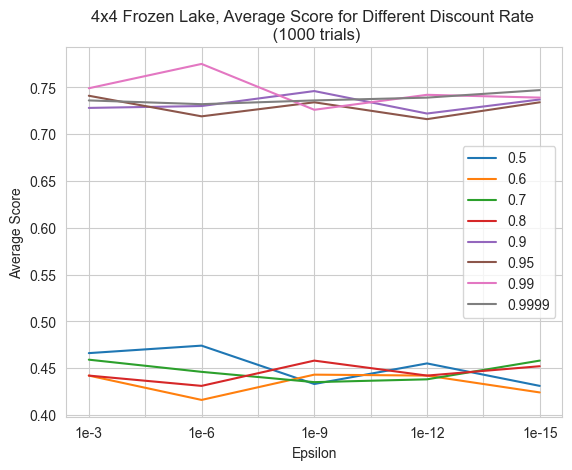

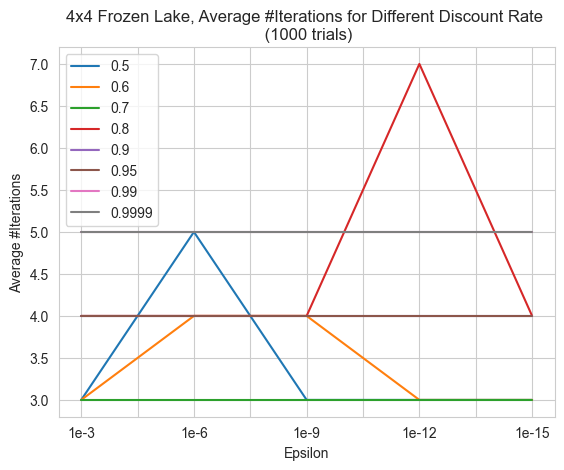

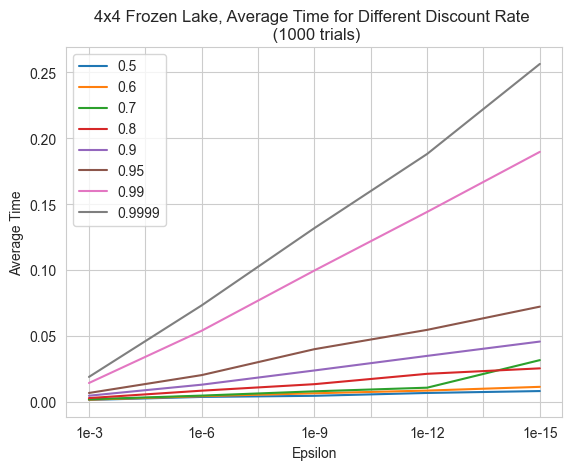

In [718]:
sns.set_style("whitegrid")
epsilon=['1e-3', '1e-6', '1e-9', '1e-12', '1e-15']
y_labels = ['Average Score', 'Average #Iterations', 'Average Time']
for i, d in enumerate([discount_r, discount_i, discount_t]):
    pd.DataFrame(d, index = epsilon).plot()
    plt.xlabel('Epsilon')
    plt.ylabel(y_labels[i])
    plt.title('4x4 Frozen Lake, {} for Different Discount Rate \n (1000 trials)'.format(y_labels[i]))

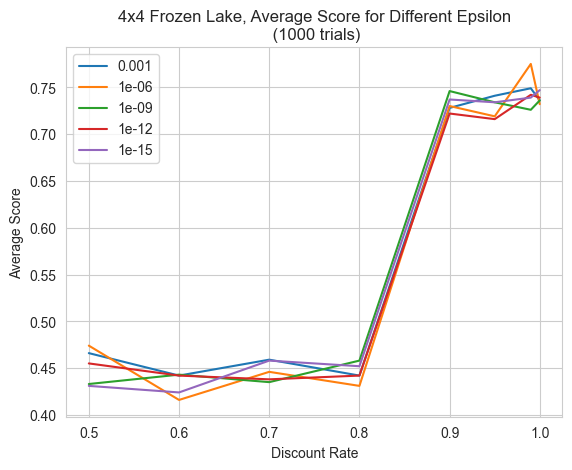

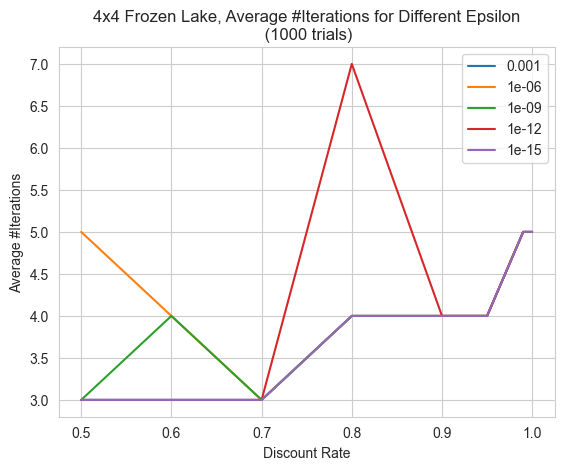

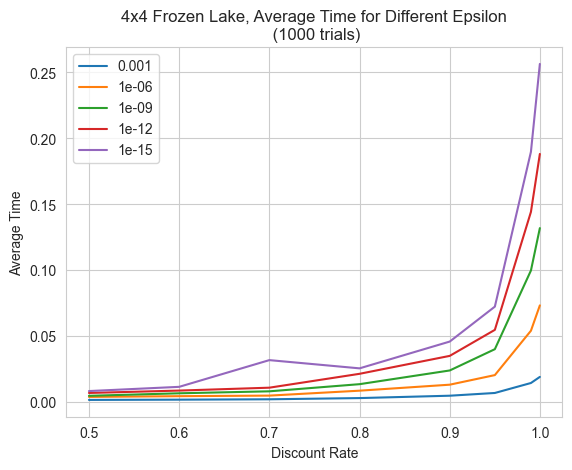

In [719]:
discount=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.9999]
y_labels = ['Average Score', 'Average #Iterations', 'Average Time']
for i, d in enumerate([epsilon_r, epsilon_i, epsilon_t]):
    pd.DataFrame(d, index = discount).plot()
    plt.xlabel('Discount Rate')
    plt.ylabel(y_labels[i])
    plt.title('4x4 Frozen Lake, {} for Different Epsilon\n (1000 trials)'.format(y_labels[i]))


In [720]:
policies = {k:v[0.001]['policy'] for k, v in pi_dict.items() if k in discount}
unique_p = []
for k,v in policies.items():
    if v not in unique_p:
        unique_p.append(v)

In [721]:
policies

{0.5: [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.6: [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.7: [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.8: [1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.9: [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.95: [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.99: [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 0.9999: [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]}

In [722]:
unique_p

[[1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0],
 [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]]

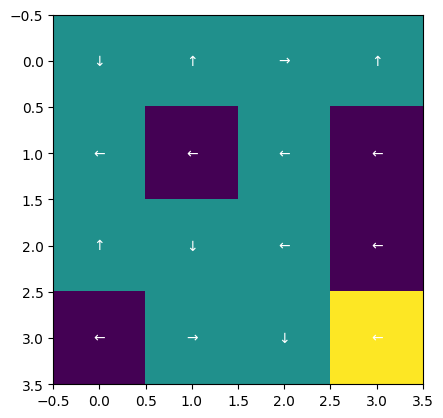

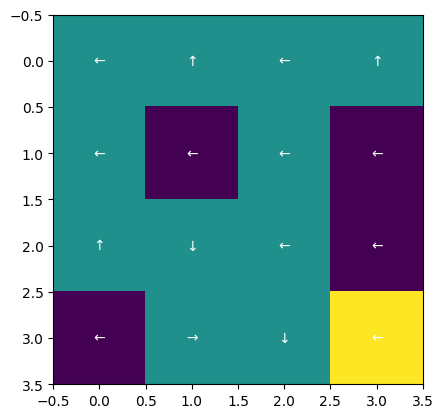

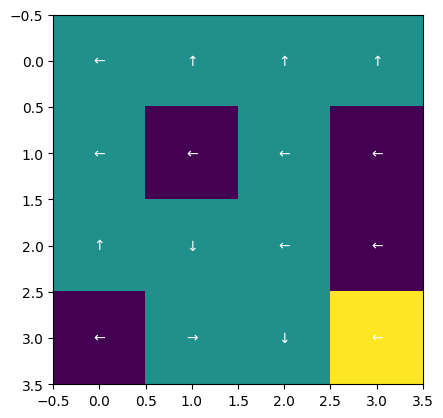

In [723]:
import matplotlib
matplotlib.rc_file_defaults()
for i in range(len(unique_p)):
    see_policy(env.action_space.n, unique_p[i])

Discount Rate 0.9 - Value Iteration v.s Policy Iteration

In [732]:
vi_ = pd.DataFrame(vi_dict[.9]).transpose().drop('policy', axis = 1)
pi_ = pd.DataFrame(pi_dict[.9]).transpose().drop('policy', axis = 1)

In [750]:
col = vi_.columns.tolist()
table_r, table_episodes, table_time = pd.concat([vi_[col[0]], pi_[col[0]]], axis = 1),\
    pd.concat([vi_[col[0]], pi_[col[1]]], axis = 1),\
    pd.concat([vi_[col[0]], pi_[col[2]]], axis = 1)
table_r.columns, table_episodes.column, table_time.column = ['VI','PI'], ['VI','PI'], ['VI','PI']
table_r.index, table_episodes.index, table_time.index = epsilon, epsilon, epsilon

/Users/siyuanliu/.conda/envs/hw2/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


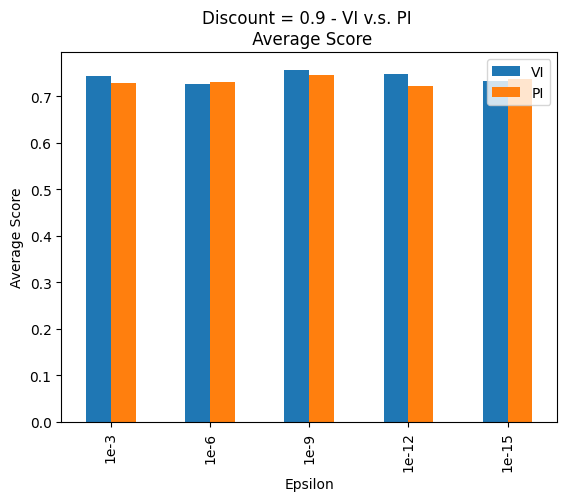

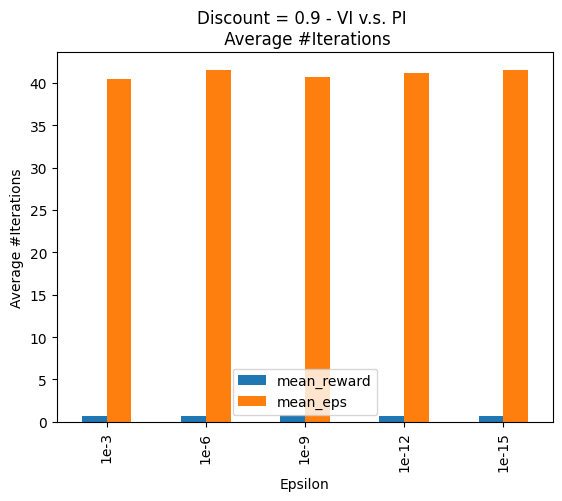

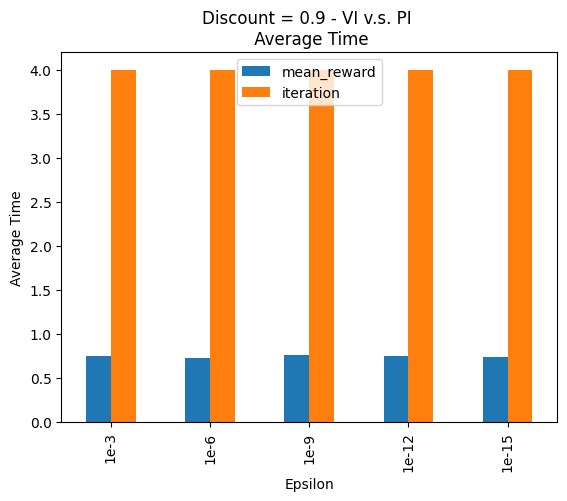

In [758]:
tables = [table_r, table_episodes, table_time]
y_labels = ['Average Score', 'Average #Iterations', 'Average Time']
for i,t in enumerate(tables):
    t.plot.bar()
    plt.xlabel('Epsilon')
    plt.ylabel(y_labels[i])
    plt.title('Discount = 0.9 - VI v.s. PI \n {}'.format(y_labels[i]))


16 * 16 Frozen Lake

In [762]:
env = FrozenLakeEnv(desc=MAPS["16x16"])
env.render()


SFFFFFFFFFFFFFFF
HFHFFFFFFFFFFFFF
FFFFFFFFHFHFFFFF
FHFFFHFFFFHHHFFF
FFFFHFFFFFHFFFFF
FFFFFFFFHFFFFFFF
FFFHFFHFFFFHFFFH
FFFHFFFFFFFFFFFF
FFFFFFFFHHFFFFHF
FFFFFFFFFFFFFFFF
HFFFFHFFFFFFFFFF
FFFHFFFHFHFFFFHF
FFFFHFHFFFFFFFHF
HHHHFFFHFFFHHFFH
FFFFHFFFFFFFHFFH
FFFFFFHFFFFHFFFG


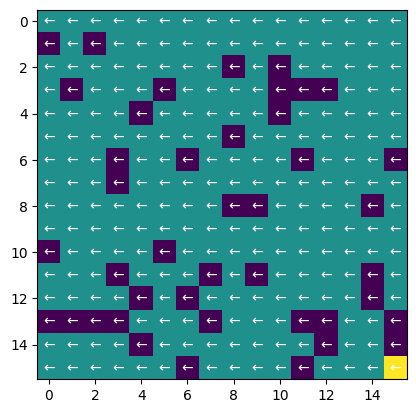

In [766]:
see_policy(16, [0] * 256)

In [ ]:
sns.set_style("whitegrid")

In [798]:
vi_dict, pi_dict = grid_search_pi_vi(env, discount=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.9999],
                                        epsilon=[1e-3, 1e-6, 1e-9, 1e-12, 1e-15], mute=True)




Solved in: 7 episodes and 0:00:00.076802 seconds
Solved in: 15 episodes and 0:00:00.107930 seconds
Solved in: 24 episodes and 0:00:00.240205 seconds
Solved in: 34 episodes and 0:00:00.317646 seconds
Solved in: 43 episodes and 0:00:00.245910 seconds
Solved in: 9 episodes and 0:00:00.045640 seconds
Solved in: 19 episodes and 0:00:00.104877 seconds
Solved in: 32 episodes and 0:00:00.183761 seconds
Solved in: 45 episodes and 0:00:00.218245 seconds
Solved in: 58 episodes and 0:00:00.290540 seconds
Solved in: 11 episodes and 0:00:00.052221 seconds
Solved in: 25 episodes and 0:00:00.129423 seconds
Solved in: 44 episodes and 0:00:00.248489 seconds
Solved in: 63 episodes and 0:00:00.323203 seconds
Solved in: 82 episodes and 0:00:00.409112 seconds
Solved in: 14 episodes and 0:00:00.146538 seconds
Solved in: 39 episodes and 0:00:00.209966 seconds
Solved in: 68 episodes and 0:00:00.355803 seconds
Solved in: 98 episodes and 0:00:00.478564 seconds
Solved in: 128 episodes and 0:00:00.631375 seconds
S

Value Iteraiton

In [799]:
discount_r, discount_i, discount_t, epsilon_r, epsilon_i, epsilon_t = convert_dict_to_dict(vi_dict)

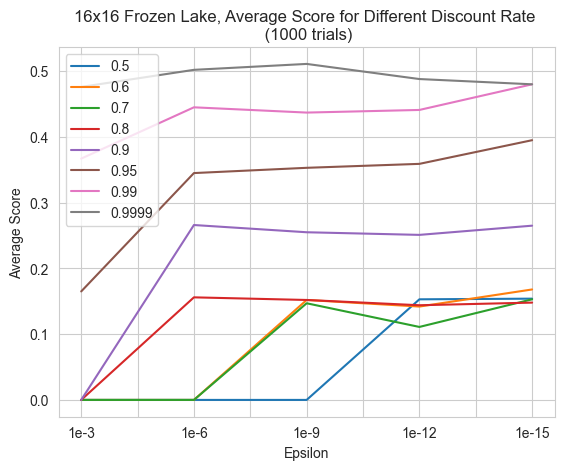

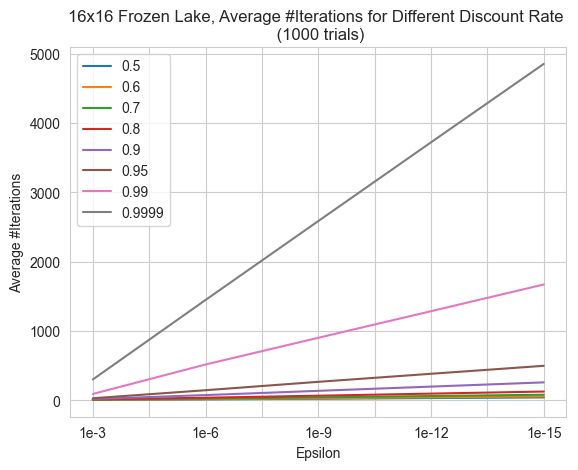

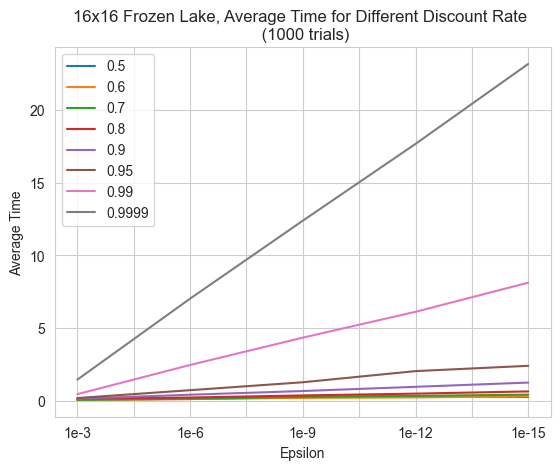

In [800]:
epsilon=['1e-3', '1e-6', '1e-9', '1e-12', '1e-15']
y_labels = ['Average Score', 'Average #Iterations', 'Average Time']
for i, d in enumerate([discount_r, discount_i, discount_t]):
    pd.DataFrame(d, index = epsilon).plot()
    plt.xlabel('Epsilon')
    plt.ylabel(y_labels[i])
    plt.title('16x16 Frozen Lake, {} for Different Discount Rate \n (1000 trials)'.format(y_labels[i]))

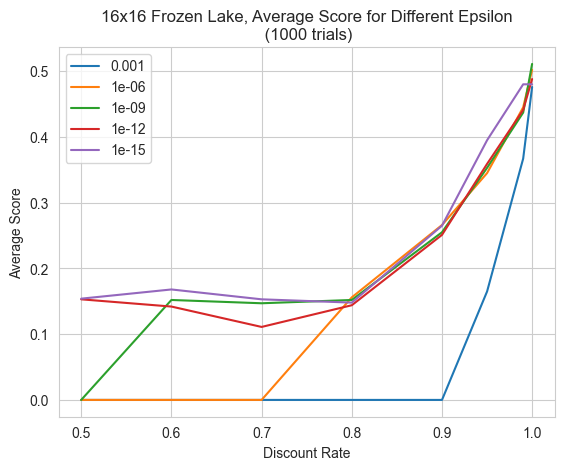

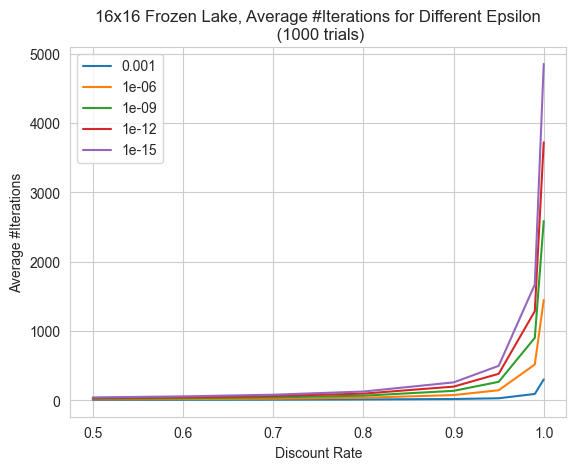

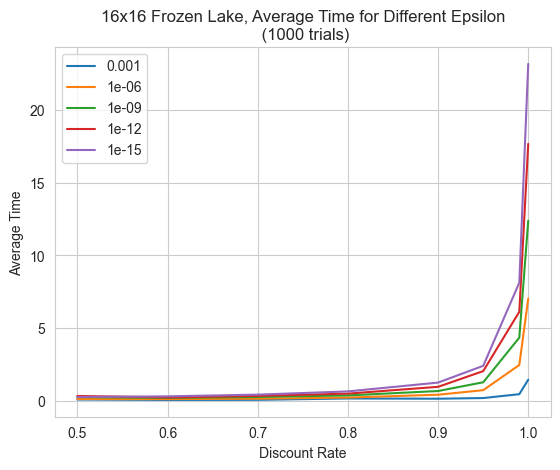

In [801]:
discount=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.9999]
y_labels = ['Average Score', 'Average #Iterations', 'Average Time']
for i, d in enumerate([epsilon_r, epsilon_i, epsilon_t]):
    pd.DataFrame(d, index = discount).plot()
    plt.xlabel('Discount Rate')
    plt.ylabel(y_labels[i])
    plt.title('16x16 Frozen Lake, {} for Different Epsilon\n (1000 trials)'.format(y_labels[i]))


In [802]:
policies = {k:v[0.001]['policy'] for k, v in vi_dict.items() if k in discount}
unique_p = []
for k,v in policies.items():
    if v not in unique_p:
        unique_p.append(v)

In [803]:
len(policies.keys())

8

In [804]:
len(unique_p)

8

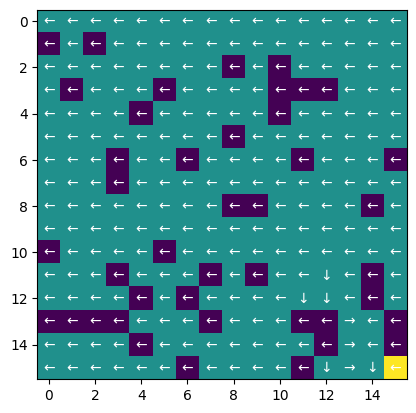

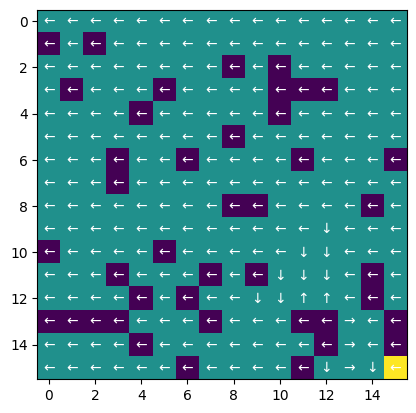

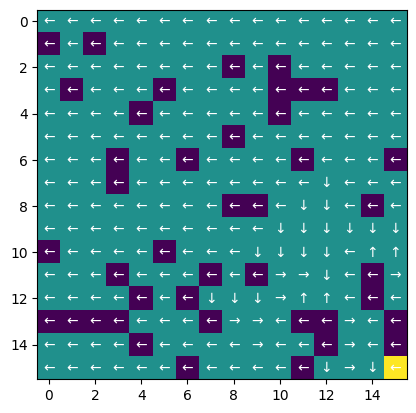

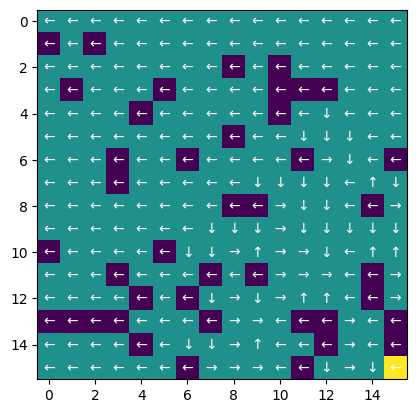

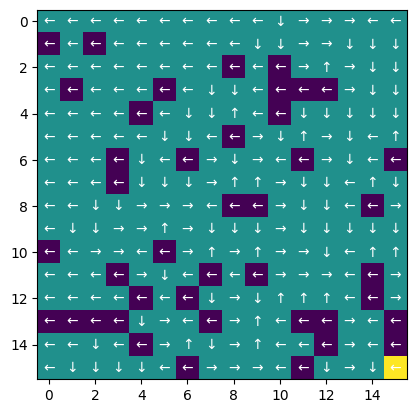

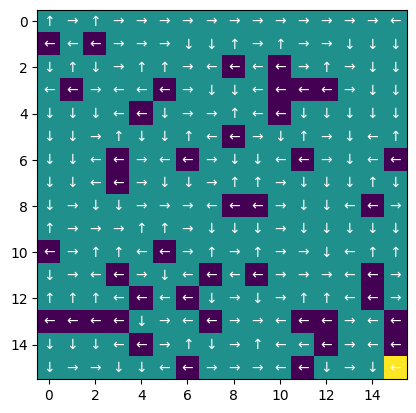

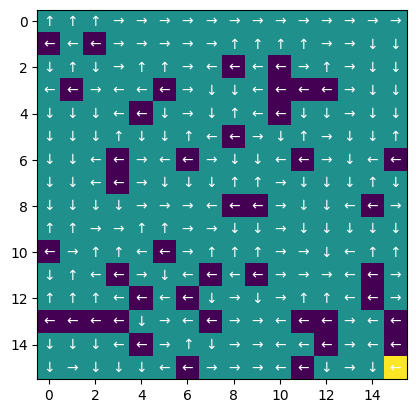

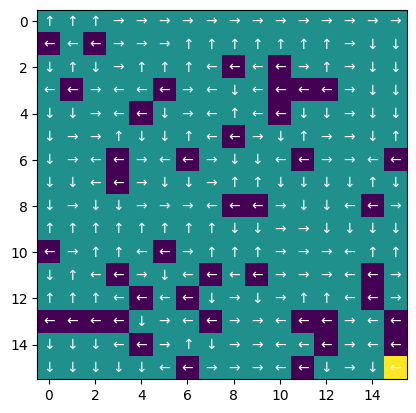

In [805]:
import matplotlib
matplotlib.rc_file_defaults()
for i in range(len(unique_p)):
    see_policy(16, unique_p[i])

Policy Iteraiton

In [806]:
discount_r, discount_i, discount_t, epsilon_r, epsilon_i, epsilon_t = convert_dict_to_dict(pi_dict)

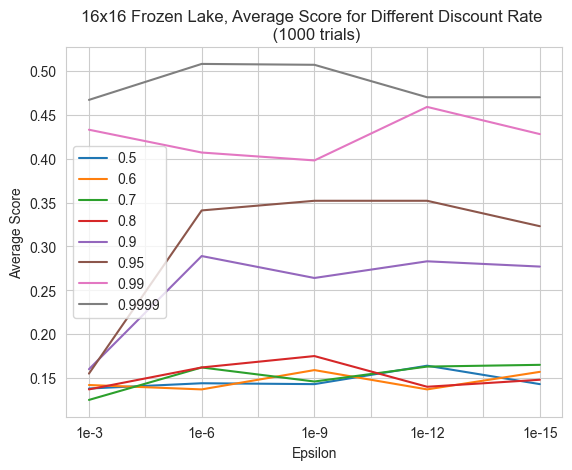

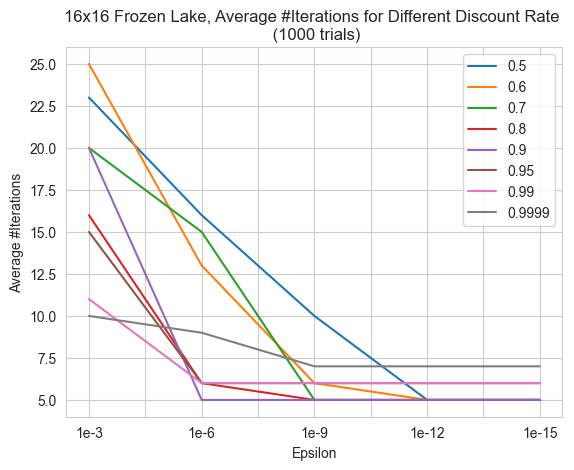

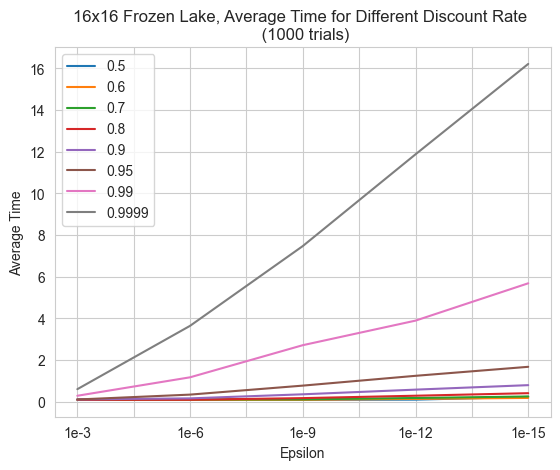

In [807]:
sns.set_style("whitegrid")
epsilon=['1e-3', '1e-6', '1e-9', '1e-12', '1e-15']
y_labels = ['Average Score', 'Average #Iterations', 'Average Time']
for i, d in enumerate([discount_r, discount_i, discount_t]):
    pd.DataFrame(d, index = epsilon).plot()
    plt.xlabel('Epsilon')
    plt.ylabel(y_labels[i])
    plt.title('16x16 Frozen Lake, {} for Different Discount Rate \n (1000 trials)'.format(y_labels[i]))

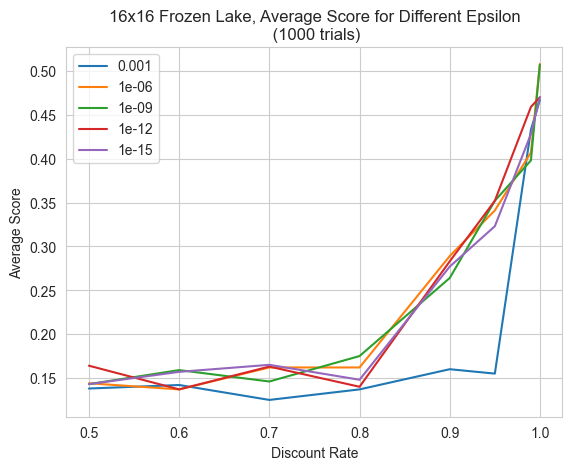

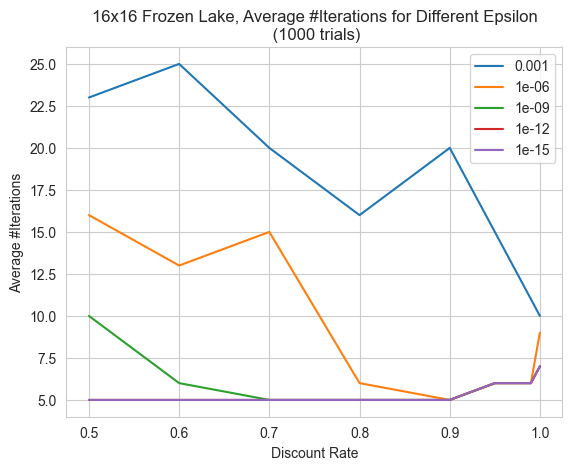

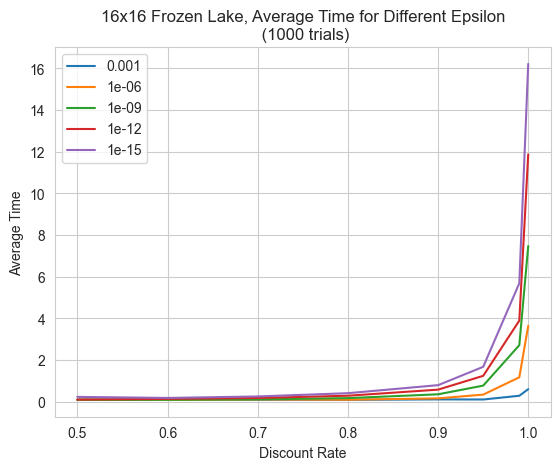

In [808]:
discount=[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.9999]
y_labels = ['Average Score', 'Average #Iterations', 'Average Time']
for i, d in enumerate([epsilon_r, epsilon_i, epsilon_t]):
    pd.DataFrame(d, index = discount).plot()
    plt.xlabel('Discount Rate')
    plt.ylabel(y_labels[i])
    plt.title('16x16 Frozen Lake, {} for Different Epsilon\n (1000 trials)'.format(y_labels[i]))


In [810]:
policies = {k:v[0.001]['policy'] for k, v in pi_dict.items() if k in discount}
unique_p = []
for k,v in policies.items():
    if v not in unique_p:
        unique_p.append(v)

In [811]:
len(policies.keys())

8

In [812]:
len(unique_p)

8

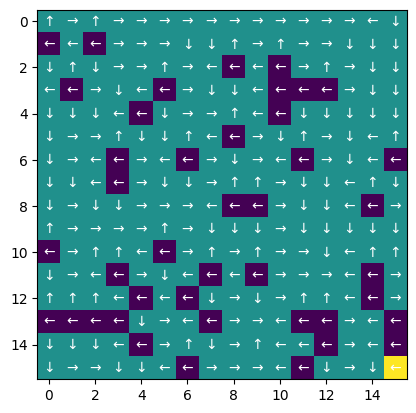

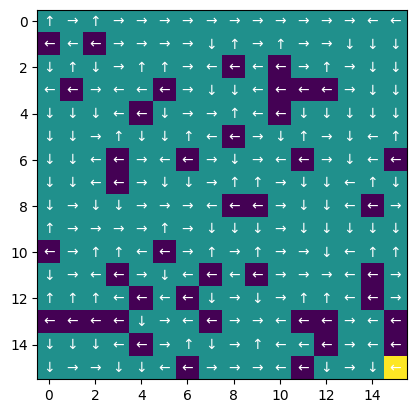

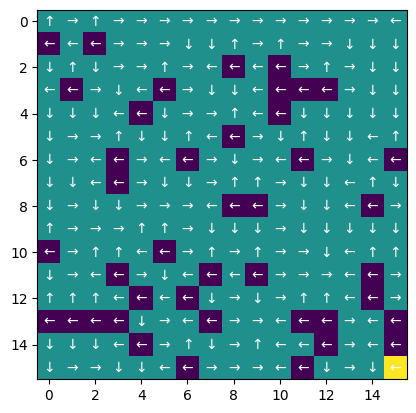

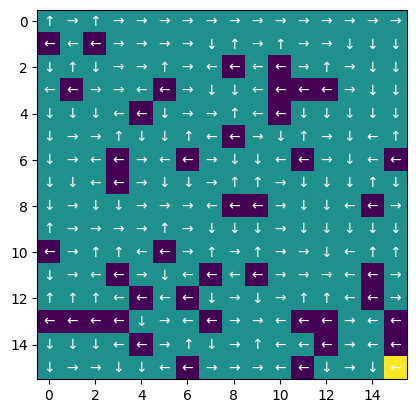

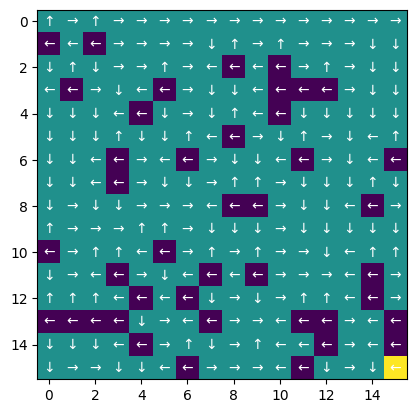

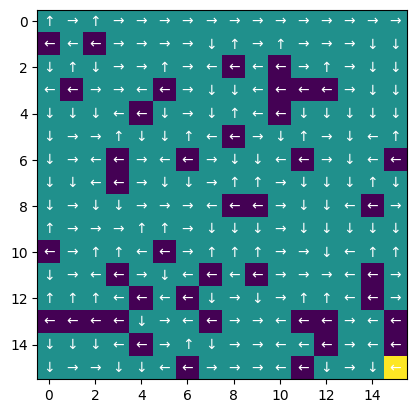

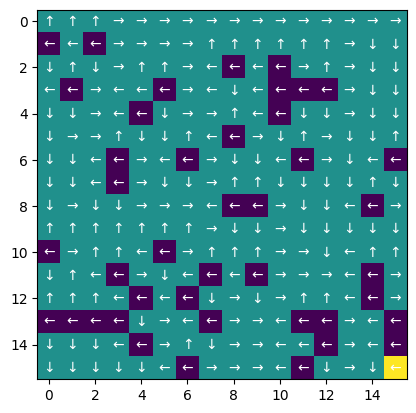

In [813]:
import matplotlib
matplotlib.rc_file_defaults()
for i in range(len(unique_p)):
    see_policy(16, unique_p[i])

Discount Rate 0.99 - Value Iteration v.s Policy Iteration

In [814]:
vi_ = pd.DataFrame(vi_dict[.99]).transpose().drop('policy', axis = 1)
pi_ = pd.DataFrame(pi_dict[.99]).transpose().drop('policy', axis = 1)

In [815]:
col = vi_.columns.tolist()
table_r, table_episodes, table_time = pd.concat([vi_[col[0]], pi_[col[0]]], axis = 1),\
    pd.concat([vi_[col[0]], pi_[col[1]]], axis = 1),\
    pd.concat([vi_[col[0]], pi_[col[2]]], axis = 1)
table_r.columns, table_episodes.column, table_time.column = ['VI','PI'], ['VI','PI'], ['VI','PI']
table_r.index, table_episodes.index, table_time.index = epsilon, epsilon, epsilon

/Users/siyuanliu/.conda/envs/hw2/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


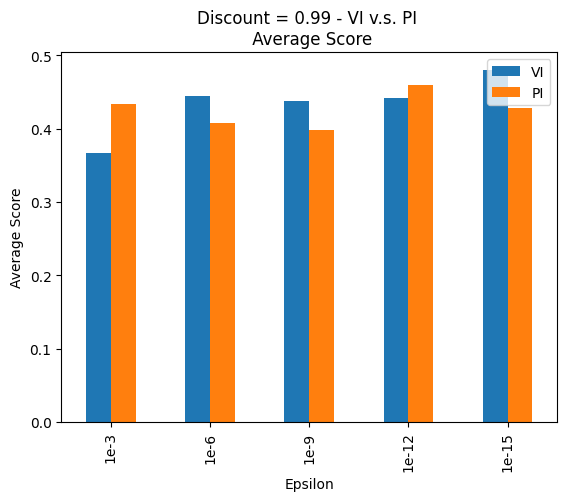

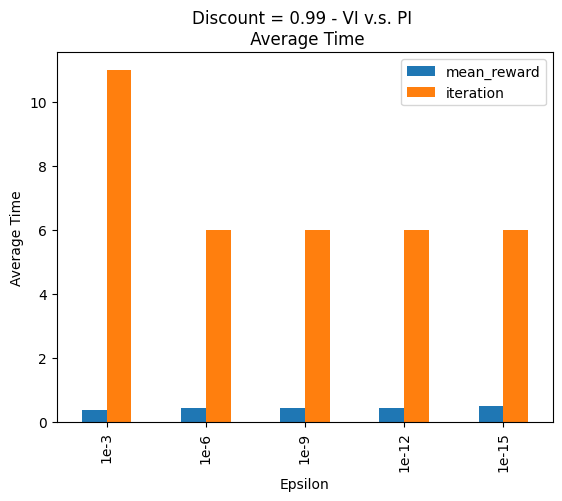

In [817]:
tables = [table_r, table_episodes, table_time]
y_labels = ['Average Score', 'Average #Iterations', 'Average Time']
for i,t in enumerate(tables):
    t.plot.bar()
    plt.xlabel('Epsilon')
    plt.ylabel(y_labels[i])
    plt.title('Discount = 0.99 - VI v.s. PI \n {}'.format(y_labels[i]))

In [ ]:
import random as rand

Q-Learning 4x4

In [1308]:
def Q_Learning(env, epochs, max_iterations, rar = 0.5, alpha=0.1, gamma=0.99, radr = 0.99, verbose=False):
    scores = np.zeros(epochs)
    max_rar = rar
    min_rar = 0.01
    Q = np.zeros((env.nS, env.nA))
    start = timer()
    for epoch in range(1, epochs + 1):
        total_reward = 0
        state = env.reset()# convert the location to a state # set the state and get first action
        done = False
        count = 0
        while True:

            # move to new location according to action and then get a new action

            if  random.uniform(0,1) < rar:
                action =  env.action_space.sample()
            else:
                b = Q[state, :]
                action = np.random.choice(np.where(b == b.max())[0])

            nextstate, reward, done, _ = env.step(action)

            # Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (r + gamma * max(Q[nextstate,:]))
            if not done:
                Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * max(Q[nextstate,:]))

                # Q[state, action] = Q[state, action] + alpha*(r + gamma*np.max(Q[nextstate, :]) - Q[state, action])
            else:
                Q[state, action] = (1 - alpha) * Q[state,action] + alpha*reward

            state = nextstate

            total_reward += reward
            count = count + 1

            # rar = max(max_rar -  (1-radr) * rar, min_rar)

            if done or count >= max_iterations:
                break


        if verbose:
            print(f"{epoch}, {total_reward}")
        if count == max_iterations:
            print('Stopped since the max_iteration has been reached!')
        rar = max(rar*radr, min_rar)
        scores[epoch - 1] = total_reward
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("Solved in: {} episodes and {} seconds".format(epochs, time_spent))
    Q_policy = Q.argmax(axis = 1)
    avg_score = np.mean(scores)

    return Q_policy, epoch, time_spent, Q, scores

In [1309]:
def grid_search_q_learning(env, gamma=[0.9], epochs=[int(1e5)], alphas=[0.1], rar = [0.8], radr=[0.99], max_iterations = 10000, mute=False):

    q_dict = {}
    for dis in gamma:
        q_dict[dis] = {}
        for eps in epochs:
            q_dict[dis][eps] = {}
            for alpha in alphas:
                q_dict[dis][eps][alpha] = {}
                for r in rar:
                    q_dict[dis][eps][alpha][r] = {}
                    for dr in radr:
                        q_dict[dis][eps][alpha][r][dr] = {}

                        # run q_learning
                        q_policy, q_solve_iter, q_solve_time, q_table, mean_r = Q_Learning(env, eps, max_iterations, r, alpha, dis, dr)
                        # q_policy, q_solve_iter, q_solve_time, q_table, mean_r = q_learning(env, dis, eps, alpha ,r, 1-dr)
                        q_mrews, q_meps, _, __ = test_policy(env, q_policy)
                        q_dict[dis][eps][alpha][r][dr]["mean_reward"] = q_mrews
                        q_dict[dis][eps][alpha][r][dr]["mean_eps"] = q_meps
                        q_dict[dis][eps][alpha][r][dr]["q-table"] = q_table
                        q_dict[dis][eps][alpha][r][dr]["rewards"] = mean_r
                        q_dict[dis][eps][alpha][r][dr]["iteration"] = q_solve_iter
                        q_dict[dis][eps][alpha][r][dr]["time_spent"] = q_solve_time
                        q_dict[dis][eps][alpha][r][dr]["policy"] = q_policy
                        if not mute:
                            print("gamma: {} total_epochs: {} lr: {}, exploration_expolidation: {}, dr: {}".format(dis, eps, alpha, r, 1-dr))
                            print("Iteration: {} time: {}".format(q_solve_iter, q_solve_time))
                            print("Mean reward: {} - mean eps: {}".format(q_mrews, q_meps))
    return q_dict

In [1310]:
def dict_to_df(the_dict):
    the_df = pd.DataFrame(columns=["Discount Rate", "Training Episodes", "Learning Rate", 'EE_rate',
                                   "Decay Rate", "Reward", "Time Spent",'Training_mean_rewards','Policy'])
    for dis in the_dict:
        for eps in the_dict[dis]:
            for lr in the_dict[dis][eps]:
                for r in the_dict[dis][eps][lr]:
                    for dr in the_dict[dis][eps][lr][r]:
                        rew = the_dict[dis][eps][lr][r][dr]["mean_reward"]
                        time_spent = the_dict[dis][eps][lr][r][dr]["time_spent"].total_seconds()
                        training_mr = the_dict[dis][eps][lr][r][dr]['rewards']
                        policy = the_dict[dis][eps][lr][r][dr]['policy']
                        dic = {"Discount Rate": dis, "Training Episodes": eps, "Learning Rate":lr, 'EE_rate':r,
                               "Decay Rate":1-dr, "Reward": rew, "Time Spent": time_spent, 'Training_mean_rewards':training_mr,
                               'Policy':policy}

                        the_df = the_df.append(dic, ignore_index=True)
    return the_df

In [1311]:
discounts=[0.99]
epochs = [int(e) for e in [1e3, 1e4, 1e5, 1e6]]
alphas = [0.01, 0.1]
rar = [0.5, 0.8, 0.9, 0.99]
radr = [1-1e-3]
q_dict = grid_search_q_learning(env, discounts, epochs,alphas, rar, radr,)

Solved in: 1000 episodes and 0:00:00.440708 seconds
gamma: 0.99 total_epochs: 1000 lr: 0.01, exploration_expolidation: 0.5, dr: 0.0010000000000000009
Iteration: 1000 time: 0:00:00.440708
Mean reward: 0.094 - mean eps: 19.77
Solved in: 1000 episodes and 0:00:00.429399 seconds
gamma: 0.99 total_epochs: 1000 lr: 0.01, exploration_expolidation: 0.8, dr: 0.0010000000000000009
Iteration: 1000 time: 0:00:00.429399
Mean reward: 0.4 - mean eps: 32.526
Solved in: 1000 episodes and 0:00:00.446909 seconds
gamma: 0.99 total_epochs: 1000 lr: 0.01, exploration_expolidation: 0.9, dr: 0.0010000000000000009
Iteration: 1000 time: 0:00:00.446909
Mean reward: 0.104 - mean eps: 28.144
Solved in: 1000 episodes and 0:00:00.212056 seconds
gamma: 0.99 total_epochs: 1000 lr: 0.01, exploration_expolidation: 0.99, dr: 0.0010000000000000009
Iteration: 1000 time: 0:00:00.212056
Mean reward: 0.045 - mean eps: 6.126
Solved in: 1000 episodes and 0:00:01.075880 seconds
gamma: 0.99 total_epochs: 1000 lr: 0.1, exploration

In [1313]:
q_df_4 = dict_to_df(q_dict)
q_df_4.shape

(32, 9)

In [1370]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

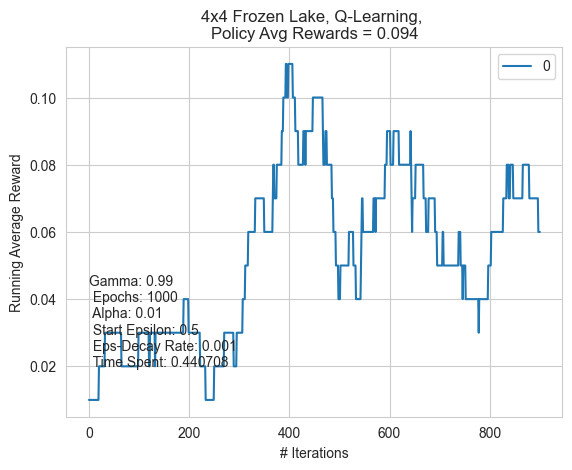

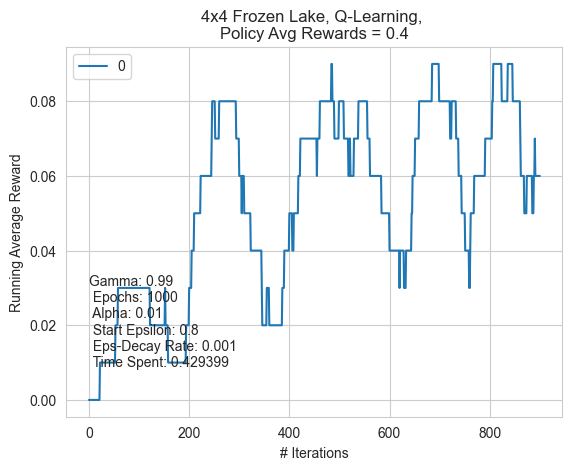

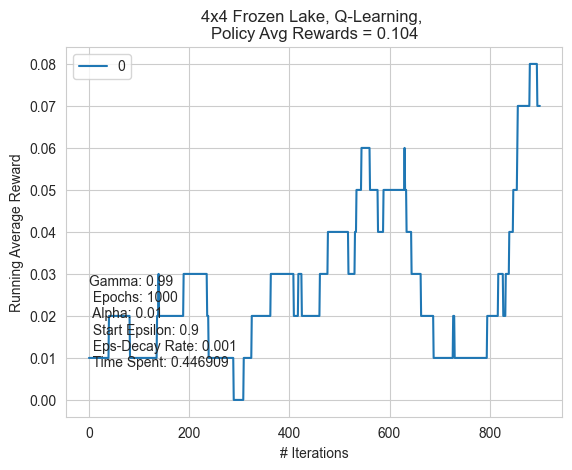

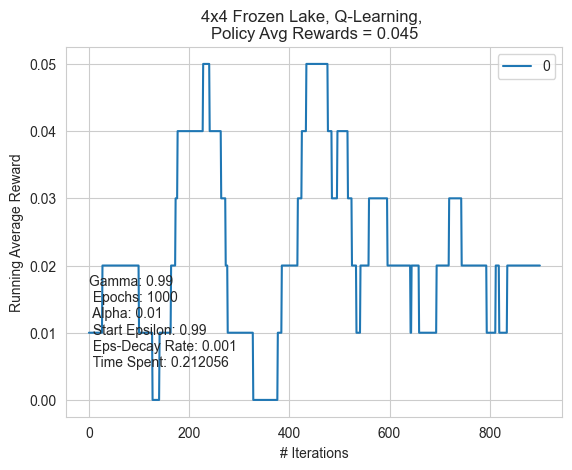

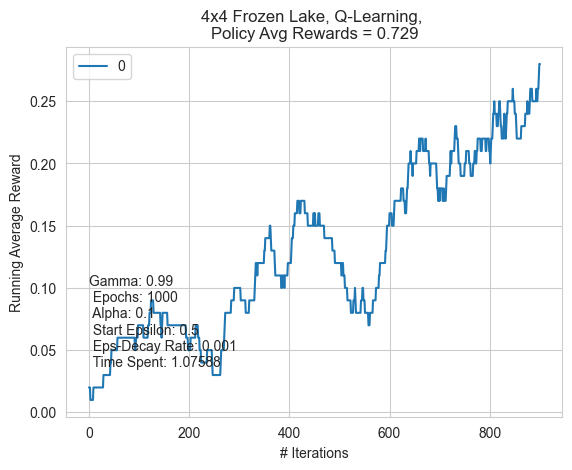

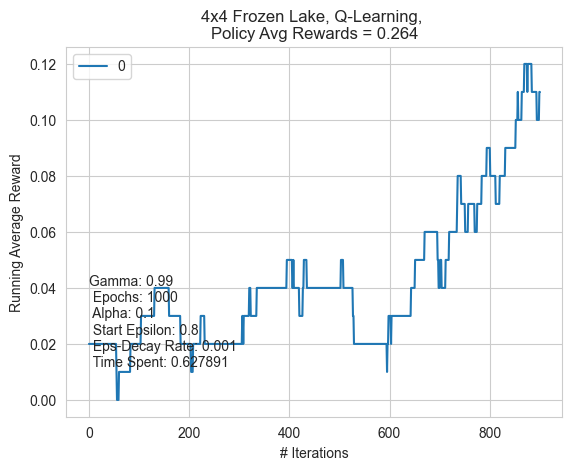

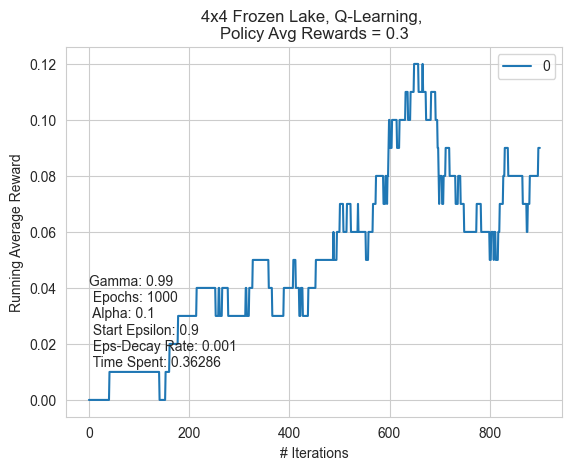

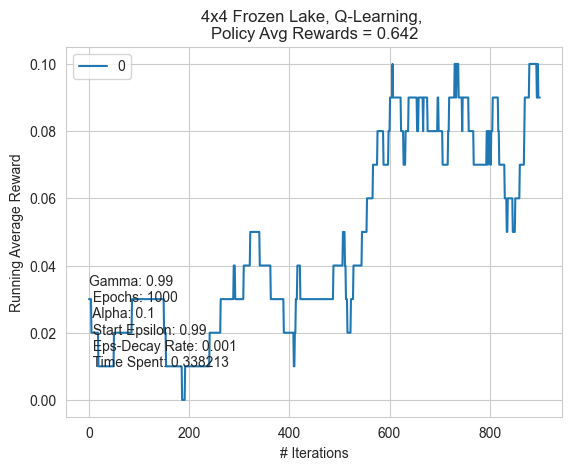

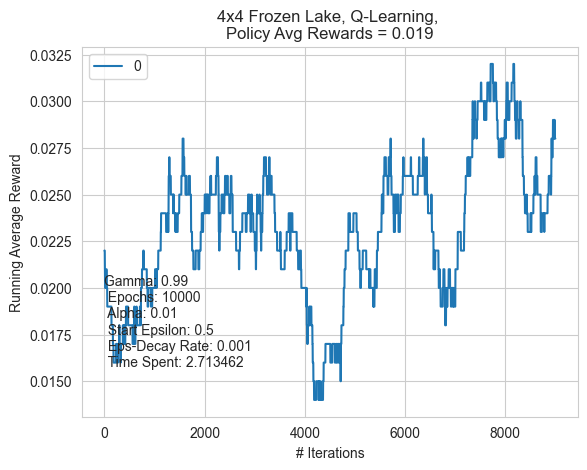

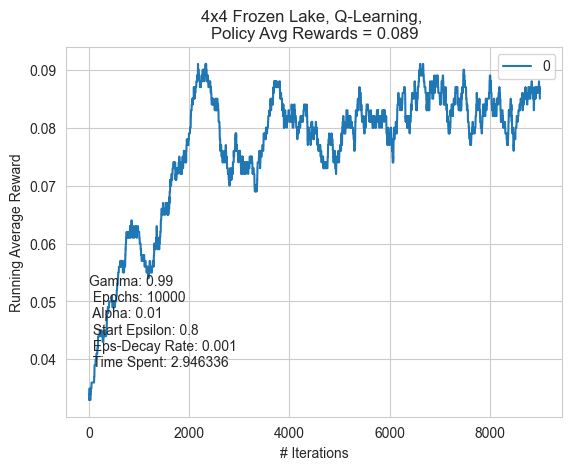

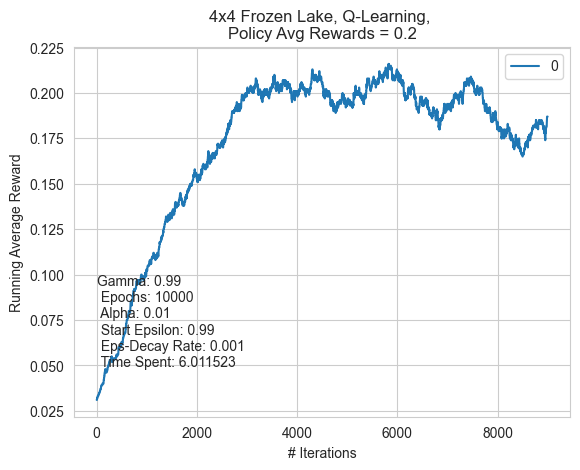

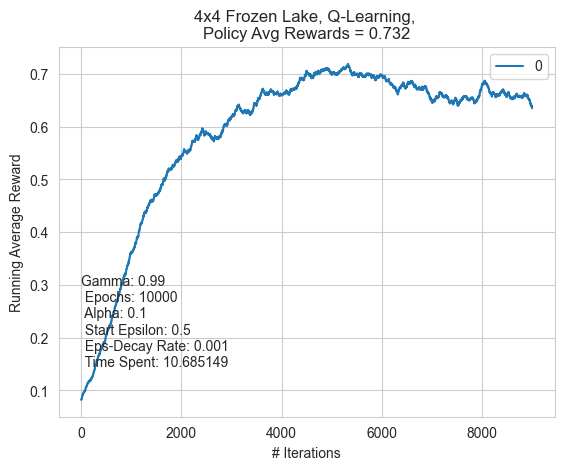

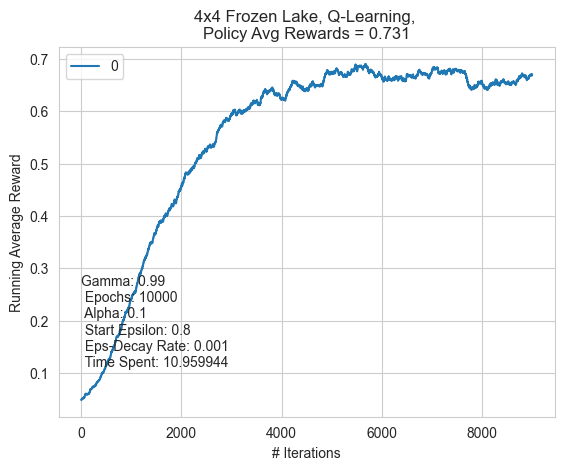

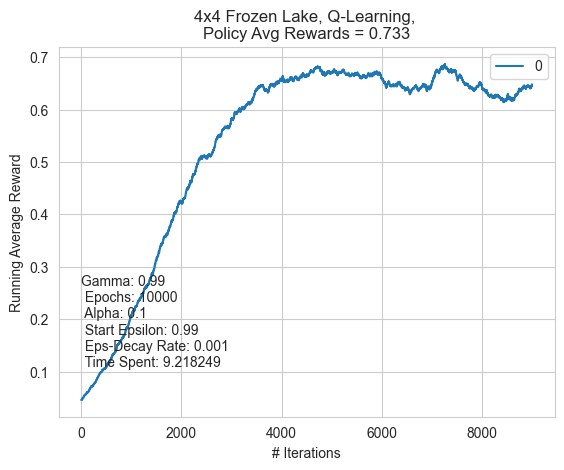

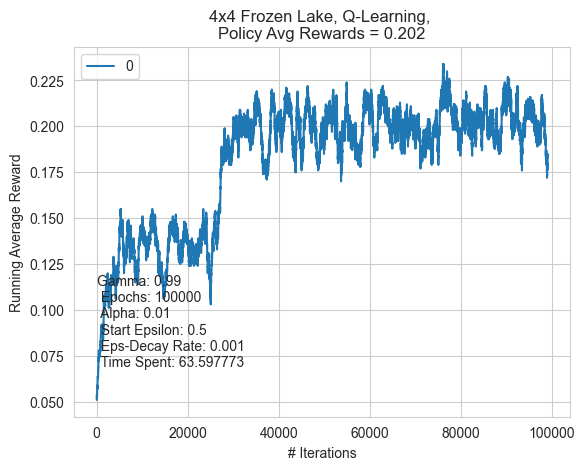

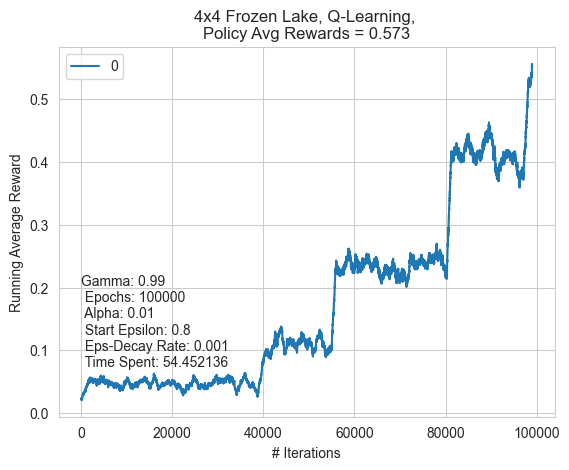

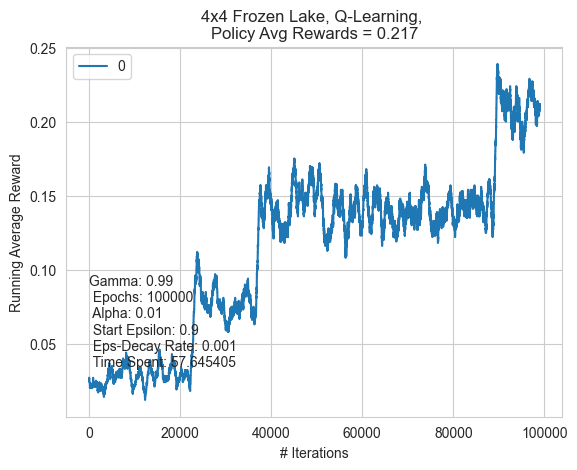

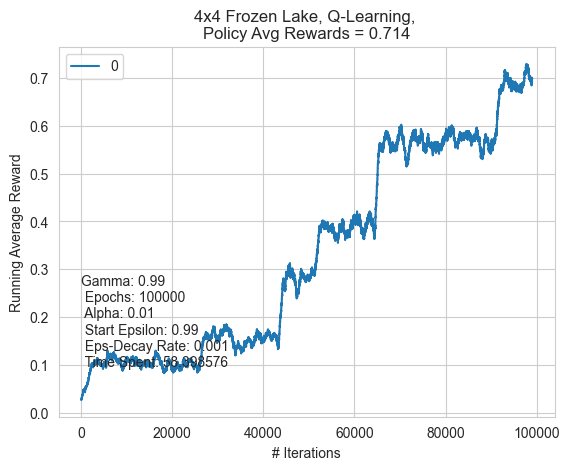

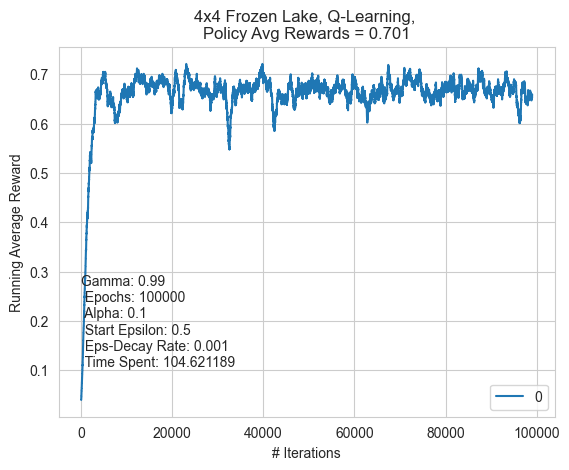

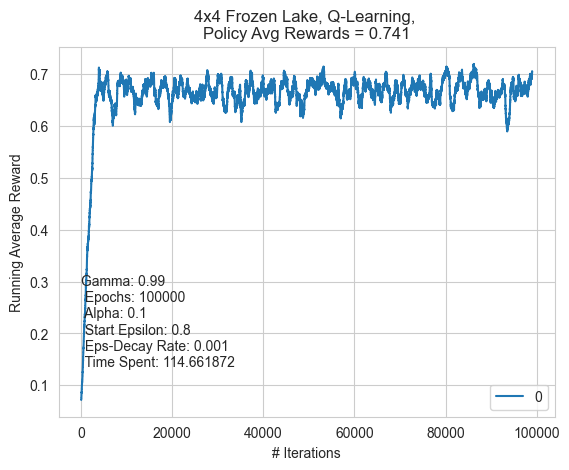

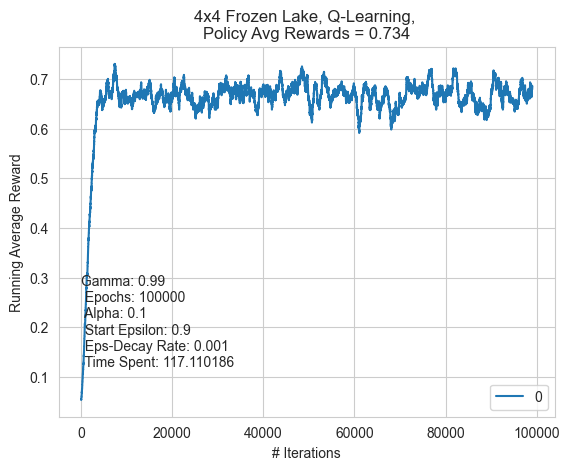

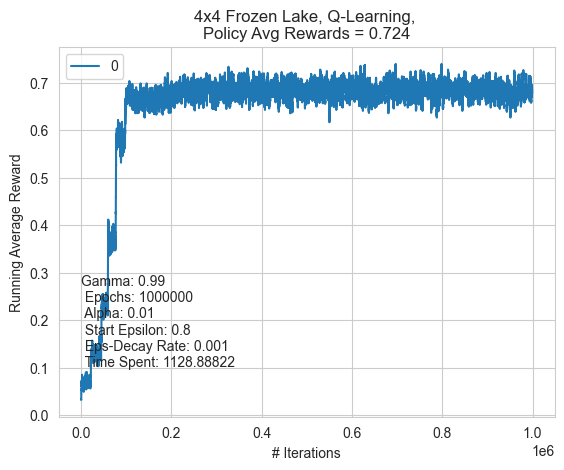

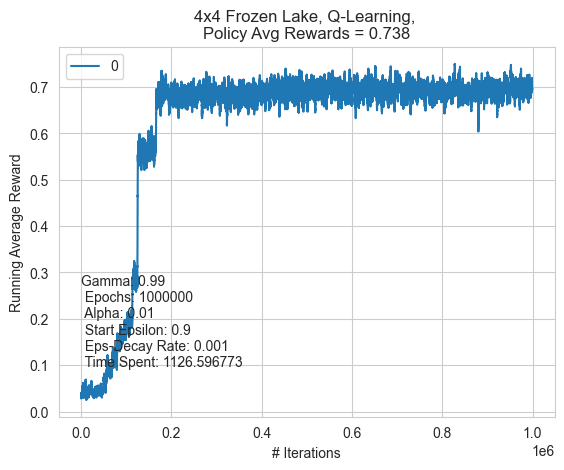

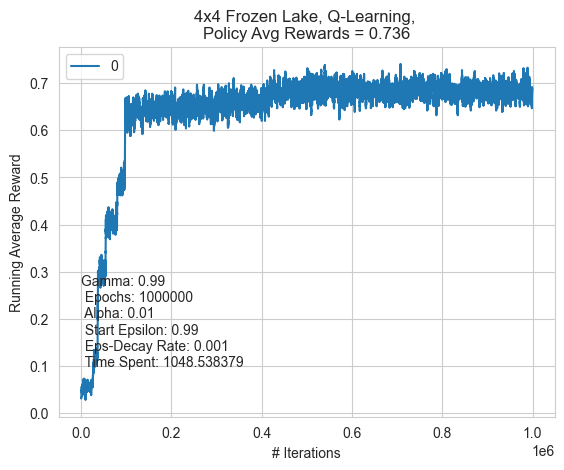

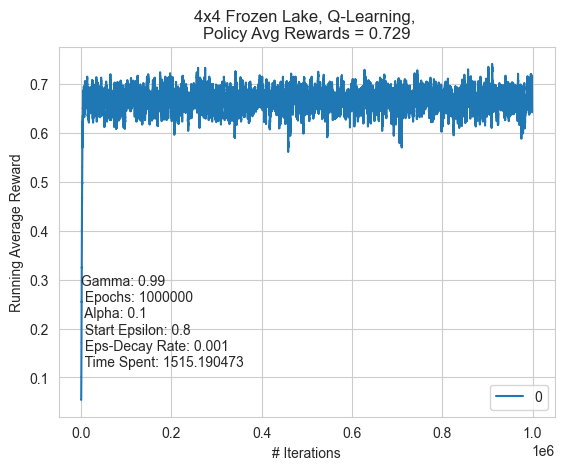

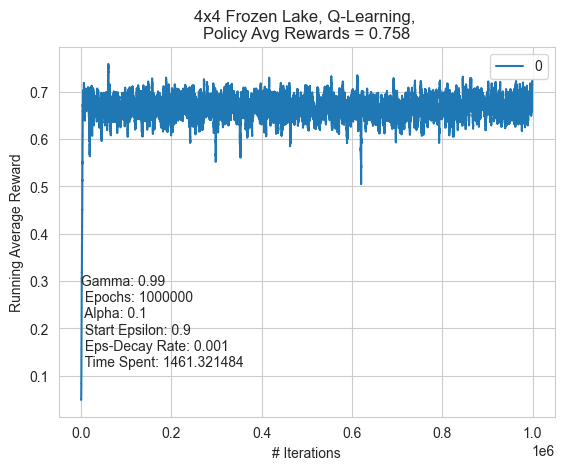

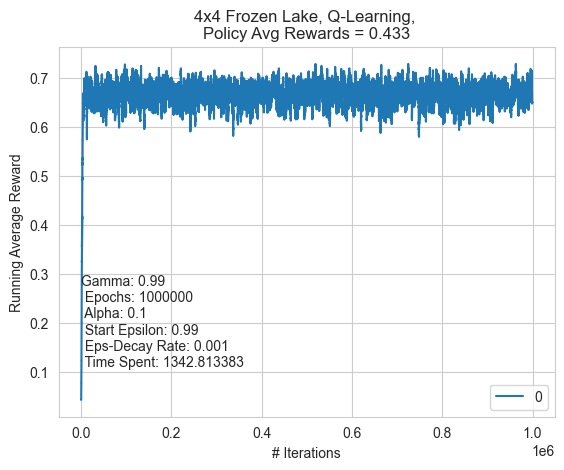

In [1379]:
sns.set_style("whitegrid")
for row in range(32):
    gamma = q_df_4.iloc[row]['Discount Rate']
    epochs = q_df_4.iloc[row]['Training Episodes']
    alpha = q_df_4.iloc[row]['Learning Rate']
    Epsilon = q_df_4.iloc[row]['EE_rate']
    Decay_Rate = round(q_df_4.iloc[row]['Decay Rate'],3)
    time = q_df_4.iloc[row]['Time Spent']
    reward = q_df_4.iloc[row]['Reward']

    if epochs == 1e3:
        cumsum= running_mean(q_df_4.iloc[row]['Training_mean_rewards'],100);

    else:
        cumsum= running_mean(q_df_4.iloc[row]['Training_mean_rewards'],1000);
    pd.DataFrame(cumsum).plot()
    plt.ylabel('Running Average Reward')
    plt.xlabel('# Iterations')
    plt.text(0,min(cumsum)+(max(cumsum) - min(cumsum))*.1, f'Gamma: {gamma} \n '
                  f'Epochs: {epochs} \n '
                  f'Alpha: {alpha} \n '
                  f'Start Epsilon: {Epsilon} \n '
                  f'Eps-Decay Rate: {Decay_Rate} \n '
                  f'Time Spent: {time}')
    plt.title('4x4 Frozen Lake, Q-Learning, \n'
              'Policy Avg Rewards = {}'.format(reward))
    plt.show()
    plt.close()

In [1404]:
q_df_4.shape

(32, 9)

In [1425]:
unique_p = []
for p in q_df_4.Policy:
    if list(p) not in unique_p:
        unique_p.append(list(p))

In [1428]:
len(unique_p)

24

In [1434]:
unique_p
rows = [i for i in q_df_4.index if list(q_df_4.iloc[i]['Policy']) == [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]]

In [1436]:
q_df_4.iloc[rows][['Discount Rate','Training Episodes', 'Learning Rate', 'EE_rate', 'Decay Rate', 'Reward', 'Time Spent']]

Discount Rate Training Episodes  Learning Rate  EE_rate  Decay Rate  \
13           0.99             10000           0.10      0.8       0.001   
14           0.99             10000           0.10      0.9       0.001   
22           0.99            100000           0.10      0.9       0.001   
26           0.99           1000000           0.01      0.9       0.001   

    Reward   Time Spent  
13   0.731    10.959944  
14   0.736    10.697978  
22   0.734   117.110186  
26   0.738  1126.596773

In [1443]:
q_df_4[['Discount Rate','Training Episodes', 'Learning Rate', 'EE_rate', 'Decay Rate', 'Reward', 'Time Spent']]

Discount Rate Training Episodes  Learning Rate  EE_rate  Decay Rate  \
0            0.99              1000           0.01     0.50       0.001   
1            0.99              1000           0.01     0.80       0.001   
2            0.99              1000           0.01     0.90       0.001   
3            0.99              1000           0.01     0.99       0.001   
4            0.99              1000           0.10     0.50       0.001   
5            0.99              1000           0.10     0.80       0.001   
6            0.99              1000           0.10     0.90       0.001   
7            0.99              1000           0.10     0.99       0.001   
8            0.99             10000           0.01     0.50       0.001   
9            0.99             10000           0.01     0.80       0.001   
10           0.99             10000           0.01     0.90       0.001   
11           0.99             10000           0.01     0.99       0.001   
12           0.99             10000           0.10     0.50       0.001   
13           0.99             10000           0.10     0.80       0.001   
14           0.99             10000           0.10     0.90       0.001   
15           0.99             10000           0.10     0.99       0.001   
16           0.99            100000           0.01     0.50       0.001   
17           0.99            100000           0.01     0.80       0.001   
18           0.99            100000           0.01     0.90       0.001   
19           0.99            100000           0.01     0.99       0.001   
20           0.99            100000           0.10     0.50       0.001   
21           0.99            100000           0.10     0.80       0.001   
22           0.99            100000           0.10     0.90       0.001   
23           0.99            100000           0.10     0.99       0.001   
24           0.99           1000000           0.01     0.50       0.001   
25           0.99           1000000           0.01     0.80       0.001   
26           0.99           1000000           0.01     0.90       0.001   
27           0.99           1000000           0.01     0.99       0.001   
28           0.99           1000000           0.10     0.50       0.001   
29           0.99           1000000           0.10     0.80       0.001   
30           0.99           1000000           0.10     0.90       0.001   
31           0.99           1000000           0.10     0.99       0.001   

    Reward   Time Spent  
0    0.094     0.440708  
1    0.400     0.429399  
2    0.104     0.446909  
3    0.045     0.212056  
4    0.729     1.075880  
5    0.264     0.627891  
6    0.300     0.362860  
7    0.642     0.338213  
8    0.019     2.713462  
9    0.089     2.946336  
10   0.060     2.043449  
11   0.200     6.011523  
12   0.732    10.685149  
13   0.731    10.959944  
14   0.736    10.697978  
15   0.733     9.218249  
16   0.202    63.597773  
17   0.573    54.452136  
18   0.217    57.645405  
19   0.714    58.398576  
20   0.701   104.621189  
21   0.741   114.661872  
22   0.734   117.110186  
23   0.730   104.828001  
24   0.742  1119.354007  
25   0.724  1128.888220  
26   0.738  1126.596773  
27   0.736  1048.538379  
28   0.655  1276.791285  
29   0.729  1515.190473  
30   0.758  1461.321484  
31   0.433  1342.813383

In [1444]:
q_df_4[q_df_4['Reward']>0.7].Policy


4     [0, 3, 0, 0, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0]
12    [0, 3, 1, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
13    [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
14    [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
15    [0, 3, 0, 1, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
19    [0, 3, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
20    [0, 3, 0, 0, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0]
21    [0, 3, 3, 3, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0]
22    [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
23    [0, 3, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
24    [0, 3, 3, 3, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0]
25    [0, 3, 0, 1, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0]
26    [0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
27    [0, 3, 0, 1, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0]
29    [0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]
30    [0, 3, 3, 3, 0, 0, 2, 0, 3, 1, 0, 0, 0, 2, 1, 0]
Name: Policy, dtype: object

Q-Learning, 16x16

In [1447]:
env = FrozenLakeEnv(MAPS['16x16'])

In [1448]:
discounts=[0.99]
epochs = [int(e) for e in [1e3, 1e4, 1e5, 1e6]]
alphas = [0.01, 0.1]
rar = [0.5, 0.8, 0.9, 0.99]
radr = [1-1e-3]
q_dict_16 = grid_search_q_learning(env, discounts, epochs,alphas, rar, radr,)



Solved in: 1000 episodes and 0:00:00.207184 seconds
gamma: 0.99 total_epochs: 1000 lr: 0.01, exploration_expolidation: 0.5, dr: 0.0010000000000000009
Iteration: 1000 time: 0:00:00.207184
Mean reward: 0.0 - mean eps: 3.068
Solved in: 1000 episodes and 0:00:00.160798 seconds
gamma: 0.99 total_epochs: 1000 lr: 0.01, exploration_expolidation: 0.8, dr: 0.0010000000000000009
Iteration: 1000 time: 0:00:00.160798
Mean reward: 0.0 - mean eps: 2.911
Solved in: 1000 episodes and 0:00:00.155478 seconds
gamma: 0.99 total_epochs: 1000 lr: 0.01, exploration_expolidation: 0.9, dr: 0.0010000000000000009
Iteration: 1000 time: 0:00:00.155478
Mean reward: 0.0 - mean eps: 3.004
Solved in: 1000 episodes and 0:00:00.273764 seconds
gamma: 0.99 total_epochs: 1000 lr: 0.01, exploration_expolidation: 0.99, dr: 0.0010000000000000009
Iteration: 1000 time: 0:00:00.273764
Mean reward: 0.0 - mean eps: 2.952
Solved in: 1000 episodes and 0:00:00.148700 seconds
gamma: 0.99 total_epochs: 1000 lr: 0.1, exploration_expolid

In [1449]:
dict_to_df(q_dict_16)


Discount Rate Training Episodes  Learning Rate  EE_rate  Decay Rate  \
0            0.99              1000           0.01     0.50       0.001   
1            0.99              1000           0.01     0.80       0.001   
2            0.99              1000           0.01     0.90       0.001   
3            0.99              1000           0.01     0.99       0.001   
4            0.99              1000           0.10     0.50       0.001   
5            0.99              1000           0.10     0.80       0.001   
6            0.99              1000           0.10     0.90       0.001   
7            0.99              1000           0.10     0.99       0.001   
8            0.99             10000           0.01     0.50       0.001   
9            0.99             10000           0.01     0.80       0.001   
10           0.99             10000           0.01     0.90       0.001   
11           0.99             10000           0.01     0.99       0.001   
12           0.99             10000           0.10     0.50       0.001   
13           0.99             10000           0.10     0.80       0.001   
14           0.99             10000           0.10     0.90       0.001   
15           0.99             10000           0.10     0.99       0.001   
16           0.99            100000           0.01     0.50       0.001   
17           0.99            100000           0.01     0.80       0.001   
18           0.99            100000           0.01     0.90       0.001   
19           0.99            100000           0.01     0.99       0.001   
20           0.99            100000           0.10     0.50       0.001   
21           0.99            100000           0.10     0.80       0.001   
22           0.99            100000           0.10     0.90       0.001   
23           0.99            100000           0.10     0.99       0.001   
24           0.99           1000000           0.01     0.50       0.001   
25           0.99           1000000           0.01     0.80       0.001   
26           0.99           1000000           0.01     0.90       0.001   
27           0.99           1000000           0.01     0.99       0.001   
28           0.99           1000000           0.10     0.50       0.001   
29           0.99           1000000           0.10     0.80       0.001   
30           0.99           1000000           0.10     0.90       0.001   
31           0.99           1000000           0.10     0.99       0.001   

    Reward  Time Spent                              Training_mean_rewards  \
0      0.0    0.207184  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1      0.0    0.160798  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2      0.0    0.155478  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3      0.0    0.273764  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4      0.0    0.148700  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5      0.0    0.166813  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
6      0.0    0.282341  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
7      0.0    0.192380  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
8      0.0    2.757994  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
9      0.0    2.244169  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
10     0.0    1.987873  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
11     0.0    2.020952  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
12     0.0    2.111364  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
13     0.0    1.956286  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
14     0.0    1.851910  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
15     0.0    1.944083  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
16     0.0   23.875688  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
17     0.0   23.120992  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
18     0.0   19.961395  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 